In [37]:
import os
import sys
sys.path.append('../..')
from shrinkbench.plot import df_from_results, plot_df, reset_plt
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import pathlib

# automatically reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def jsonfile(file):
    with open(file, 'r') as f:
        s = json.load(f)
    return s

In [73]:
# plot results
results_dir = "/network/scratch/m/marwa.el-halabi/PruningResults"  
# dataset = "MNIST" 
# model = "LeNet"  # "LeNet", "vgg11_bn_small_mnist"
dataset = "CIFAR10"
model = "vgg11_bn_small" 
name = 'all' #, 'fc1', 'fc2', 'classifier.0', 'classifier.3'
# ['features.0',
#  'features.4',
#  'features.8',
#  'features.11',
#  'features.15',
#  'features.18',
#  'features.22']
job_id = "1421840" 
if name is 'all':
    results_path = f"{results_dir}/{dataset}-{model}-{job_id}"
    df = df_from_results(results_path, structured=True, icml=True)
    df = df[(df['model'] == model) & (df['dataset'] == dataset) ]
else:
    results_path = f"{results_dir}/onelayer-pruning/{dataset}-{model}-{job_id}"
    df = df_from_results(results_path, structured=True)
    df = df[(df['model'] == model) & (df['dataset'] == dataset) & (df['prune_layers'] == name)] 
cf_key = 'fraction' 
print("# of rows in df: ", len(df))
config_file = results_path+'/config.json'
if os.path.isfile(config_file): 
    config = jsonfile(config_file)
    fractions = config['fractions'] if 'fractions' in config.keys() else [i * 0.1 for i in range(0, 11)]
    #fractions = [i * 0.1 for i in range(0, 11)]
    print(fractions)
    structure = config['structure'] if 'structure' in config.keys() else 'neuron'
    print(structure)
    
    # create folder for figs and save config file in it
    fig_path = pathlib.Path(f"./figs/{dataset}-{model}-{job_id}")
    fig_path.mkdir(parents=True, exist_ok=True)
    config_file = fig_path / 'config.json'
    if not config_file.is_file():
        json.dump(config, open(config_file, 'w'), indent=4)

number of folders skipped:  0
# of rows in df:  830
[0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
neuron


In [68]:
def format_plot(plt, xaxis, yaxis):
    if yaxis in ["acc1", "acc5"]:
        plt.ylabel('Top-1 accuracy' if yaxis=="acc1" else "Top-5 accuracy")
       
    if xaxis == 'fraction':
                plt.xlabel(f'Fraction of prunable {structure}s kept')
                plt.xscale('linear')
                plt.xlim(0, 1)
                plt.ylim(0, 1)
    else:  #if xaxis == 'speedup':
        x_max = df[xaxis].max()
        x_min = df[xaxis].min()
        ticks = np.arange(x_min, x_max, len(fractions))
        plt.xticks(ticks)
        plt.gca().set_xticklabels(map(str, ticks))
#    ax = plt.gca()
#     handles, labels = ax.get_legend_handles_labels()
#     labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
#     ax.legend(handles, labels)
    plt.rc('font', size=35)
    plt.rc('legend', fontsize=25)

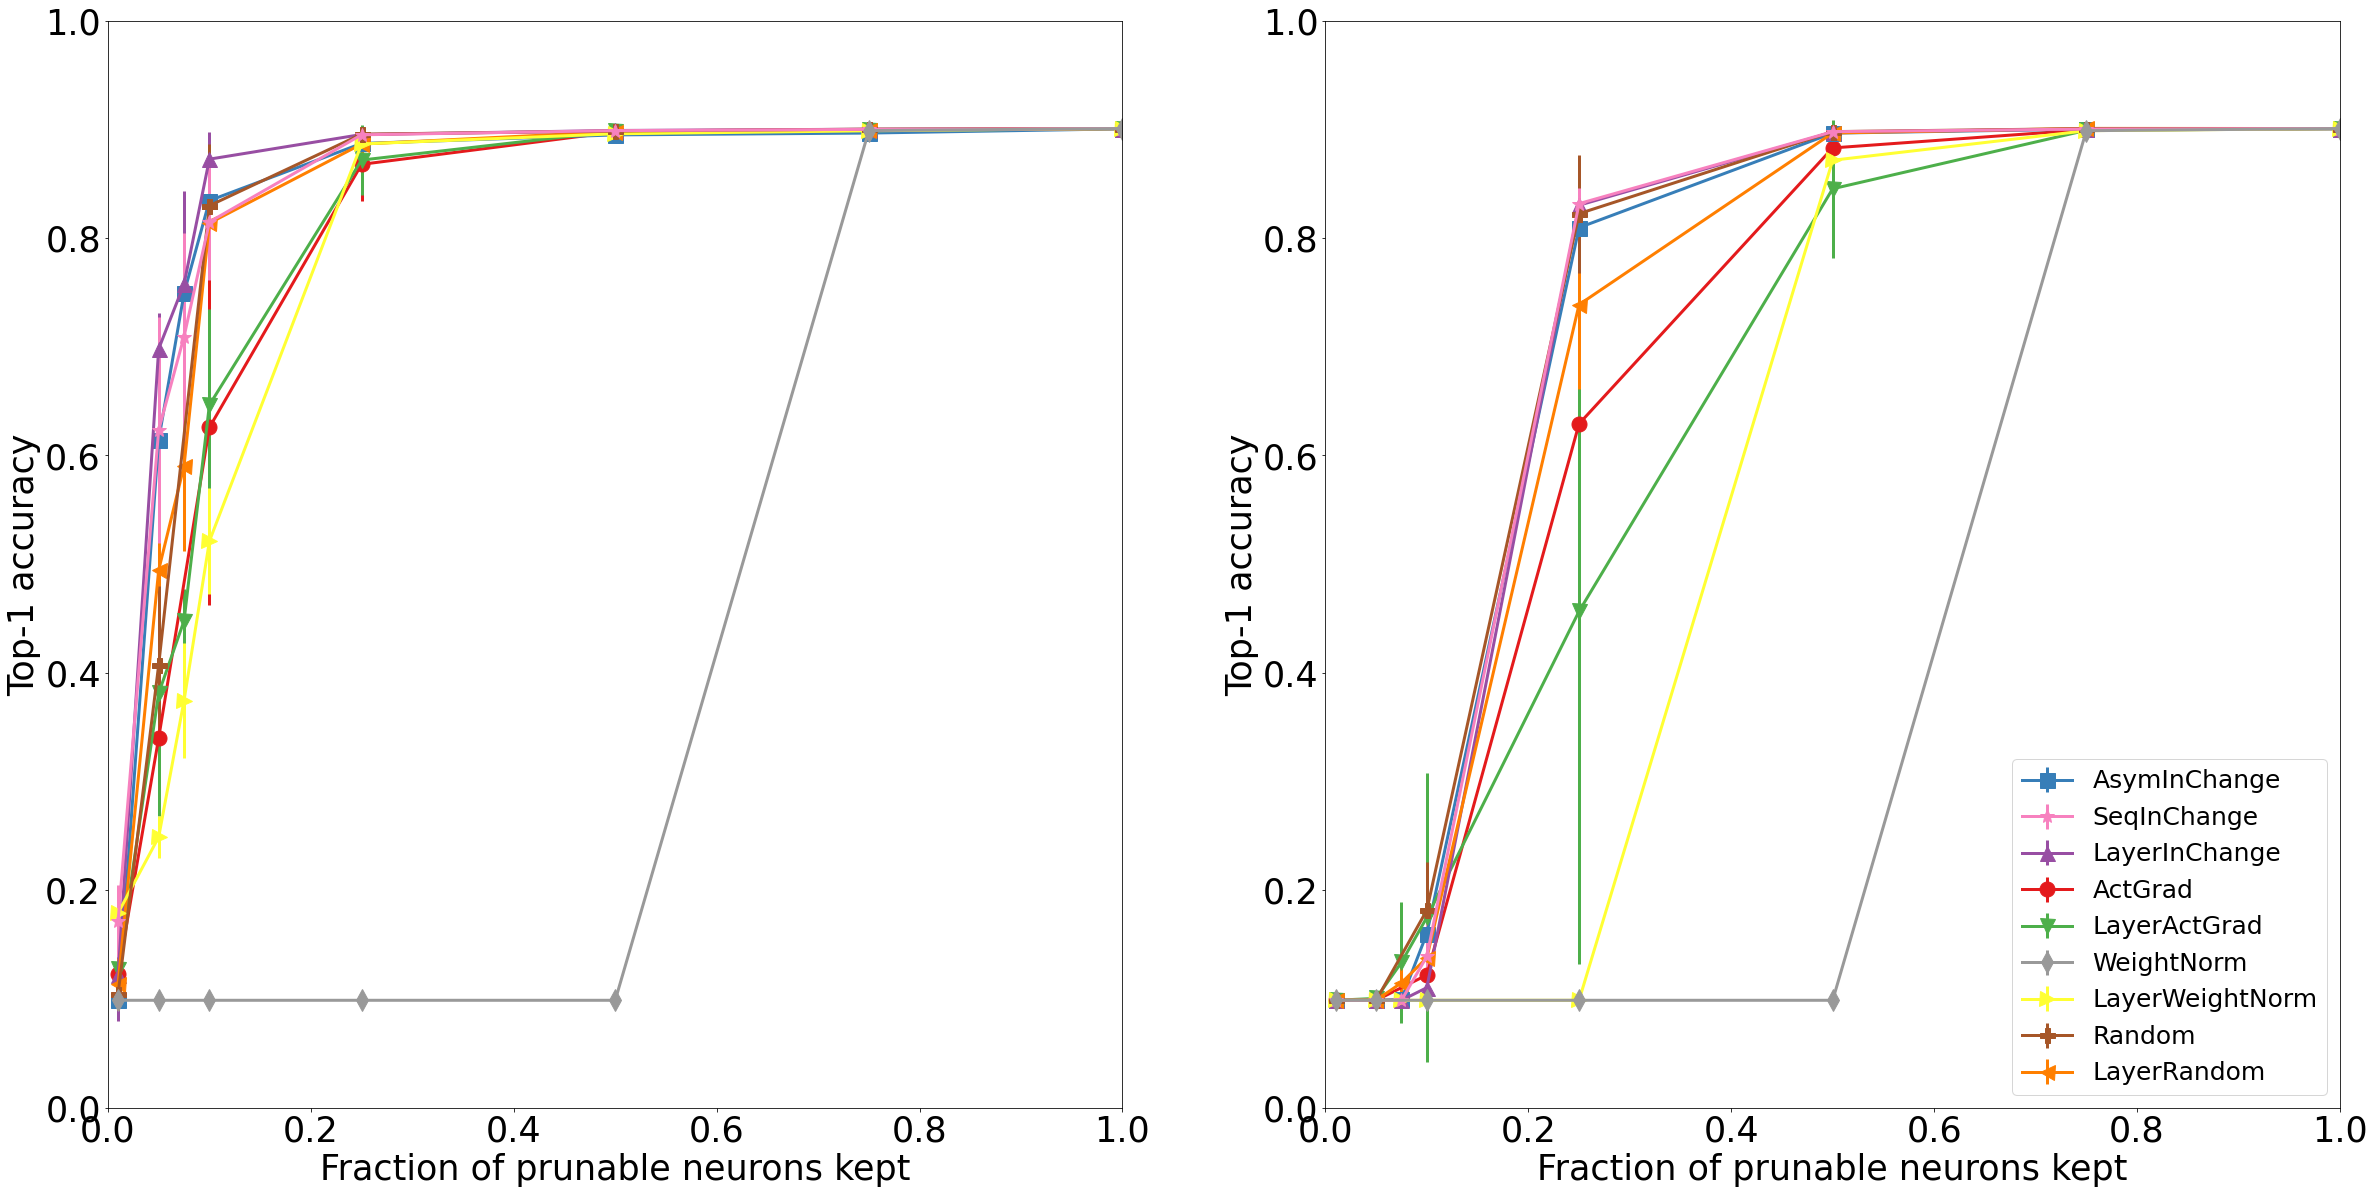

In [74]:
reset_plt()
save_fig = True

order = {
 'Random': 8,
 'ActGrad': 4,
 'WeightNorm': 6,
 'LayerRandom': 9, 
 'SeqInChange': 2,
 'AsymInChange': 1,
 'LayerActGrad': 5,
 'LayerInChange': 3,
 'LayerWeightNorm': 7
}
ft = False
# choose which acc after fine-tuning to plot (max or last)
post_acc = 'post_' #'last_'
include = 'all'
exclude = ['NotIncluded']

idx = np.logical_and(df['strategy'].isin(include), ~df['strategy'].isin(exclude)) if include is not 'all' else ~df['strategy'].isin(exclude) 
df_idx = df[idx]
for yaxis in ['acc1']: #'acc1' ,'acc5' ,'pruning_time', 'finetuning_time'
    for xaxis in [cf_key]: #cf_key, 'real_compression', 'speedup']:
        fig, ax = plt.subplots(1,2, figsize=(40, 20), sharey=True)
        for idx, reweight in enumerate([True, False]):
            plt.subplot(1, 2, idx+1)
            sub_df = df_idx[df_idx['reweight'] == reweight]
            suffix = '- reweighted' if reweight else ''
            rw_title = ("with" if reweight else "no") + " reweighting"
            alpha = 1
            #alpha = 0.4 if not reweight else 1
            if yaxis in ["acc1", "acc5"]:
                min_acc = min(df['pre_' + yaxis].min(), df[post_acc + yaxis].min())
                if not ft:
                    plot_df(sub_df, xaxis, 'pre_' + yaxis, markers='strategy', line='-', fig=False, colors='strategy',
                            alpha=alpha, markersize=15, linewidth=3) 
                    format_plot(plt, xaxis, yaxis)
                else:
                    plot_df(sub_df, xaxis, post_acc + yaxis, markers='strategy', fig=False, colors='strategy', 
                           alpha=alpha, markersize=15, linewidth=3) #suffix=suffix, 
                    format_plot(plt, xaxis, yaxis)

            else: 
                fig = plt.figure(figsize=(15, 8))
                min_time = df[yaxis].min()
                max_time = df[yaxis].max()
                plot_df(sub_df, xaxis, yaxis, markers='strategy', fig=False, colors='strategy',
                        alpha=alpha, markersize=10) # suffix=suffix + '- pre'
                format_plot(plt, xaxis, yaxis)
                plt.ylim(min_time, max_time)
                plt.title(f'{dataset}-{model}, {rw_title}')

                
        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: order[t[0]]))
        ax.legend(handles, labels)
        if save_fig:
            plt.savefig(fig_path / f'{yaxis}-{xaxis}{"-finetuned" if ft else ""}-{job_id}-{name}.png')


plt.show()

In [22]:
sub_df = df[df['fraction']==0.25]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(df)


,dataset,model,prune_layers,strategy,fraction,pruning_time,size,size_nz_orig,size_nz,real_compression,flops,flops_nz,speedup,pre_acc1,pre_acc5,post_acc1,post_acc5,last_acc1,last_acc5,finetuning_time,seed,batch_size,train_kwargs,completed_epochs,path,reweight,structure
528,MNIST,LeNet,all,ActGrad,0.010,0.025810,60074,60074,60074,1.000000,247272,188372.0,1.312679,0.096915,0.488430,0.112243,0.512757,0.112243,0.505439,21.098628,42,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-162956-XAJI-fa5407667ef241fef588d0ba2e66f3ff,False,neuron
573,MNIST,LeNet,all,ActGrad,0.010,0.620486,60074,60074,49174,1.221662,247272,188372.0,1.312679,0.094739,0.493770,0.112243,0.512757,0.112243,0.510483,21.621360,42,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-162926-XAJI-f485239b08b193e368bcfbf6775e300f,True,neuron
515,MNIST,LeNet,all,ActGrad,0.010,0.526909,60074,60074,49174,1.221662,247272,188372.0,1.312679,0.094739,0.493770,0.112243,0.512757,0.112243,0.510483,22.177049,43,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-163933-BZFQ-5eebedbfd8f3c5814607de025fdd2442,True,neuron
617,MNIST,LeNet,all,ActGrad,0.010,0.025329,60074,60074,60074,1.000000,247272,188372.0,1.312679,0.096915,0.488430,0.112243,0.515625,0.112243,0.510483,27.077469,43,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-164003-BZFQ-50489f7961ada06b17f6f58951d9629e,False,neuron
606,MNIST,LeNet,all,ActGrad,0.010,0.035587,60074,60074,49248,1.219826,247272,188763.0,1.309960,0.178501,0.573576,0.178501,0.573576,0.112243,0.510483,21.627813,44,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-164939-OT5G-caaa0a59980919154b33aae7e4d5ca77,True,neuron
687,MNIST,LeNet,all,ActGrad,0.010,0.026633,60074,60074,60074,1.000000,247272,188763.0,1.309960,0.181962,0.581092,0.373022,0.966871,0.373022,0.966871,21.934967,44,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-165010-OT5G-164c493046872b5effe21dbc2bbd05dc,False,neuron
526,MNIST,LeNet,all,ActGrad,0.010,0.026773,60074,60074,60074,1.000000,247272,188372.0,1.312679,0.096915,0.488430,0.112243,0.512757,0.112243,0.512757,22.229657,45,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-170016-JRCM-28717bd9b09f4b80c64ea11e23a9fdb2,False,neuron
654,MNIST,LeNet,all,ActGrad,0.010,0.034941,60074,60074,49174,1.221662,247272,188372.0,1.312679,0.094739,0.493770,0.112243,0.512757,0.112243,0.512757,23.172002,45,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-170016-JRCM-af442a5041c69a1b83275200a39bab9a,True,neuron
516,MNIST,LeNet,all,ActGrad,0.010,0.052599,60074,60074,49174,1.221662,247272,188372.0,1.312679,0.094739,0.493770,0.112243,0.515625,0.112243,0.510483,24.724643,46,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-171054-5OV4-061d04862da3e1d7ce137dd9d1da631c,True,neuron
599,MNIST,LeNet,all,ActGrad,0.010,0.027594,60074,60074,60074,1.000000,247272,188372.0,1.312679,0.096915,0.488430,0.112243,0.515625,0.112243,0.510483,22.579204,46,128,"{'optim': 'Adam', 'epochs': 10, 'optim_kwargs': {'lr': 0.001}}",11,/network/scratch/m/marwa.el-halabi/PruningResults/MNIST-LeNet-1420121/20211211-171124-5OV4-a958d0a3af429d2cbb8ecc1bc6d67bcf,False,neuron
